# Demo: Basics of Exponential Integrators

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg # needed for matrix exponential
import scipy.integrate
import time

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

The purpose of this demo is to investigate *exponential integrators*. This is a fancy way of saying that we're looking at what happens when we take the variations of parameters formula for first-order ODEs seriously! 

## Selected References

-Cox & Matthews, JCP, 2002 https://doi.org/10.1006/jcph.2002.6995

-Bowman & Pineau, conference slides, 2018 https://www.math.ualberta.ca/~bowman/talks/cms18.pdf

-Bowman, CQAM, 2006 https://www.math.ualberta.ca/~bowman/publications/ode05camq.pdf

-Hochbruck & Ostermann, Acta Numerica, 2010 https://doi.org/10.1017/S0962492910000048

# Review: Matrix Exponentials, Variation of Parameters. and Propagators

Suppose $A\in \mathbb{R}^{n\times n}$ is a fixed matrix and $f\colon \mathbb{R}\times \mathbb{R}^{n}$ is a sufficiently nice (say, $C^1$) function. $f(t,\mathbf{x})$ does not need to be affine in $\mathbf{x}$! For a fixed $\mathbf{x}_{0}$, we consider the initial value problem
$$ \dot{\mathbf{x}}(t) = A\mathbf{x}(t) +f(t,\mathbf{x}(t)) \quad \text{such that} \quad \mathbf{x}(0)=\mathbf{x}_{0}.$$
In an ODEs course, you learn that the linear part of the ODE in question can be simplified by introducing an *integrating factor*, namely 
$$ e^{tA} \doteq \sum_{k=0}^{\infty}\frac{1}{k!}\left(tA\right)^{k} \in \mathbb{R}^{n\times n}. $$
Using the formula $\frac{\mathrm{d}}{\mathrm{d}t}\left(e^{tA}\right) = e^{tA}A$ (strictly speaking, the order of multiplication does not matter here since any matrix commutes with its exponential), our ODE can be rewritten as
$$ 
\frac{\mathrm{d}}{\mathrm{d}t}\left(e^{-tA}\mathbf{x}(t)\right) = e^{-tA}f\left(t,\mathbf{x}(t)\right). 
$$
Integrating over $[0,t]$, applying the fundamental theorem of calculus, and doing a bit of re-arranging gives 
$$ 
\mathbf{x}(t) = e^{tA}\mathbf{x}_{0} + \int_{0}^{t} e^{(t-s)A}f(s,\mathbf{x}(s)) \ \mathrm{d}s.
$$
This is known as the *variation of parameters formula* (or, in Euro literature, the *variation of constants formula*) for first-order inhomogeneous systems of ordinary differential equations, applied after we pretend the nonlinear part of our right-hand side is a forcing term. If we replace $A$ by a suitable linear operator on a Banach space (say, $A=\Delta$, the Laplacian), then the variation of parameters formula is more often called *Duhamel's principle*. For brevity, we henceforth use "VoP" as shorthand for "the variation of parameters formula". 

Notice that, in linear case $f\equiv 0$, we recover the simple formula
$$ \mathbf{x}(t) = e^{tA}\mathbf{x}_{0} . $$
So, the matrix exponential "propagates" the initial data to the current state. For this reason, the $t$-parameterized family of matrices (linear operators) $e^{tA}$ is called the *propagator* associated to the linear differential operator 
$$ \frac{\mathrm{d}}{\mathrm{d} t} - A . $$

# Using VoP to Construct Numerical Methods

There are plenty of different ways to build useful numerical methods from VoP, but for today we only focus on the two simplest cases. We'll see that the simplest of such methods performs pretty poorly, but a just-so-slightly smarter method can hold its own against really optimized algorithms like LSODA (https://doi.org/10.1137/0904010). As we have come to expect by now, both methods involve constructing a sequence $\mathbf{x}_{n}\approx x(t_{n})$ of approximate solution values sampled at finitely many prescribed times $t_{n}$. For simplicity, today we suppose our time-steps are evenly spaced. That is, we choose a small time-step $h$ and impose 
$$ t_{n+1}-t_{n} = h \quad \forall \ n. $$ 
Now, if we go back to the derivation of VoP, we could just as well integrate over $[t_{n}, t_{n+1}]$ instead of $[0,T]$. This would yield, after some algebra,
$$ 
\mathbf{x}(t_{n+1}) = e^{hA}\mathbf{x}(t_{n}) + \int_{0}^{h} e^{(h-s)A}f(s+t_{n},\mathbf{x}(s+t_{n})) \ \mathrm{d}s.
$$
If we carelessly replace $\mathbf{x}(t_{n+1}),\mathbf{x}(t_{n})$ by their approximate values, then 
$$ 
\mathbf{x}_{n+1} = e^{hA}\mathbf{x}_{n} + \int_{0}^{h} e^{(h-s)A}f(s+t_{n},\mathbf{x}(s+t_{n})) \ \mathrm{d}s.
$$
We can now obtain numerical methods by choosing different approximations of the integral on the right-hand side. 

## Simplest Method: Integrating Factor Euler (IFEuler)

If we approximate the integral by a left-endpoint Riemann sum and again ignore the difference between $\mathbf{x}(t_{n})$ and $\mathbf{x}_{n}$, we obtain 
$$ \mathbf{x}_{n+1} = e^{hA}\left(\mathbf{x}_{n} + hf(t_{n},\mathbf{x}_{n})\right). 
$$
This is know as the *Integrating Factor Euler method (IFEuler)*, since it essentially amounts to just discretizing by the usual forward Euler method after introducing our integrating factor (the propagator $e^{tA}$). Therefore, this method obviously has order 1. We see below through numerical experiments that IFEuler has some serious shortcomings, making it even worse that the vanilla forward Euler scheme!

## A Better Method: First-Order Exponential Time-Differencing (ETD1)

Let's try a smarter idea: instead of pretending the entire integrand on the right-hand side of VoP is constant, we instead only assume the forcing term is constant:
$$ f(s+t_{n},\mathbf{x}(s+t_{n})) \approx f(t_{n}, \mathbf{x}_{n}) \quad \forall \ s\in [0,h].$$
We then resolve the action of the propagator $e^{(h-s)A}$ on this constant **exactly**; this means we are doing *exponential quadrature*. The resulting scheme reads
$$ 
\mathbf{x}_{n+1} = e^{hA}\mathbf{x}_{n} + \left[\int_{0}^{h} e^{(h-s)A} \ \mathrm{d}s\right] f(t_{n}, \mathbf{x}_{n}) .
$$
The integral is easily computed: 
$$ \int_{0}^{h} e^{(h-s)A} \ \mathrm{d}s = -A^{-1}\left[e^{(h-s)A}\right]_{s=0}^{h} = A^{-1}\left[e^{hA}-I\right],$$
where $I$ denotes the $n\times n$ identity matrix. If we define the matrix function 
$$ \varphi_{1} \colon \mathrm{GL}\left(n,\mathbb{R}\right)\rightarrow \mathbb{R}^{n\times n}, \quad \varphi_{1}(B) = B^{-1}\left(e^{B}-I\right),$$
then we can write our method as 
$$ 
\mathbf{x}_{n+1} = e^{hA}\mathbf{x}_{n} + h\varphi_{1}\left(hA\right)f(t_{n}, \mathbf{x}_{n}) .
$$
This is the *exponential Euler method*, or the *exponential time-differencing method of order 1*. The latter name is abbreviated as ETD1: for a proof that the "order 1" part of the name is justified, see Theorem 2.7 in Hochbruck & Ostermann. A bit more algebra shows that ETD 1 can be re-arranged as
$$ 
\mathbf{x}_{n+1} = \mathbf{x}_{n} + h\varphi_{1}\left(hA\right)\left(A\mathbf{x}_{n}+ f(t_{n}, \mathbf{x}_{n}) \right).
$$
This latter form of the method may be preferable in situations where $n\gg1$ and $A$ is very sparse, since **exponentiation does not preserve sparsity**. 

Some small remarks about EDT1 are in order. First, we can generalize ETD1 to higher-order schemes by replacing $f(s+t_{n},\mathbf{x}(s+t_{n}))$ in VoP with a degree $p$ interpolating polynomial. The gain in order comes at the cost of computing a bunch of matrix functions $\varphi_{k}$ ($k=1,...,p$), which may be costly if $n\gg 1$. The reader interested in further details may consult the references for explicit examples of higher-order exponential time-differencing methods. Second, $\varphi_{1}$ involves a subtraction, which from our understanding of floating-point arithmetic can present serious cancellation issues. This problem won't show up in the examples I present in this demo, but be aware that it exists and that numerical linear algebraists are looking for ways around it. 

## Immediate Theoretical Remarks on IFEuler and ETD1

### Remark A: Equilibria
Suppose that $f$ has no explicit dependence on $t$, and that $\mathbf{x}_{*}$ is an equilibrium of our ODE. This means
$$ 0 = A\mathbf{x}_{*} + f(\mathbf{x}_{*})$$
and that $\mathbf{x}_{*}$ is the unique solution to 
$$ \dot{\mathbf{x}}(t) = A\mathbf{x}(t) +f(t,\mathbf{x}(t)) \quad \text{such that} \quad  \mathbf{x}_{0} = \mathbf{x}_{*}.$$
Ideally, we want any numerical method to preserve equilibria: in other words, if there is some $n$ so that $\mathbf{x}_{n}=\mathbf{x}_{*}$, then we should also have $\mathbf{x}_{m}=\mathbf{x}_{*}$ for all $m\geq n$, at least up to machine accuracy. A trivial induction argument shows that forward Euler and ETD1 have this property. However, for IFEuler, 
$$ \mathbf{x}_{n+1} = e^{hA}\left(\mathbf{x}_{*} + hf(\mathbf{x}_{*})\right) = e^{hA}\left(1-hA\right)x_{*} = x_{*} + \mathcal{O}\left(h^2\right),
$$
where we have used the Taylor series of the exponential to obtain the last expression. So, the ability of IFEuler to reproduce equilibria is discretization-dependent! This is a big problem, and we'll see below that it can in practice ruin simulations of very routine equations. 

### Remark B: A-Stability
By construction, ETD1 treats the linear part of our ODE **and** the action of the propagator on the nonlinear part of the ODE exactly. This means that, without doing any further work, ETD1 is A-stable: there is no potential of errors amplifying a "bad" eigenvector of $A$ and causing instability. TODO: discuss whether or not IFEuler is A-stable, with explanation... I think it should be?


# Example 1: Relaxation to Equilibrium for a Nonlinear Scalar Equation

To get the basics of the methods introduced above we start off with an easy example from the slides of Bowman & Pineau. We look at a scalar problem $(n=1)$: 
$$
y'(t) + y = \cos(y) \quad \text{such that} \quad y(0) =1. 
$$
Drawing a picture (do it!) shows that this autonomous equation has a unique, stable equilibrium $y_{*}\approx 0.74$. Therefore, the solution of this IVP should relax to $y_{*}$ exponentially quickly. Accordingly, this is a great problem to test how badly IFEuler fails at reproducing equilibria. 

First, we define the parameters of the problem and the discretization, and specify how we are going to store our data for plotting. 

In [2]:
T = 5. # total simulation runtime
h = 5e-2 # time-step
N= np.int(T/h) # total number of time samples

y0 = 1. # initial state

y =np.zeros(N, dtype=float) # array for storing solution samples. 
y[0]=y0

Since this problem just involves rapid relaxation to equilibrium, it's harmless to take forward Euler as our benchmark solution. Below, we run forward Euler, IFEuler, and ETD1 up to time $T$. 

In [3]:
# Euler discretization
for n in np.arange(1,N):
    y[n]= (1.-h)*y[n-1]+h*np.cos(y[n-1])

y_euler = np.copy(y)

# IF Euler discretization
for n in np.arange(1,N):
    y[n]= np.exp(-h)*(y[n-1]+h*np.cos(y[n-1]))
    
y_IF = np.copy(y)

# EDTE1 discretization

for n in np.arange(1,N):
    y[n]= np.exp(-h)*y[n-1]+(1-np.exp(-h))*np.cos(y[n-1])
    
y_ETD1 = np.copy(y)

Since we're interested in looking at relaxation, it's a good idea to plot $y-y_{*}$ rather than $y$. Thus, we should get an accurate guess of $y_{*}$, which is super easy to do via fixed-point iteration. Note that we could also use $\texttt{scipy.optimize.fsolve}$ for this task, but I think it's good to make all your code as simple as possible. 

In [4]:
speed_flag = True 

y_eq = 0.7 # from Wolfram Alpha, this is one-digit accurate

while speed_flag == True: 

    new_guess = np.cos(y_eq) # get a new guess at fixed point iterating the map
    
    speed = np.abs(new_guess-y_eq) # check speed of convergence
    
    if speed < 1e-16: # set tolerance to whatever you want...since this is an easy problem,
        # I can ask for machine precision and still get great performance
        
        speed_flag = False # stop if slowdown is too much
        
    y_eq = new_guess # update guess

print('equilibrium point = ', y_eq)

equilibrium point =  0.7390851332151607


Now, we plot the solutions for all three methods. 

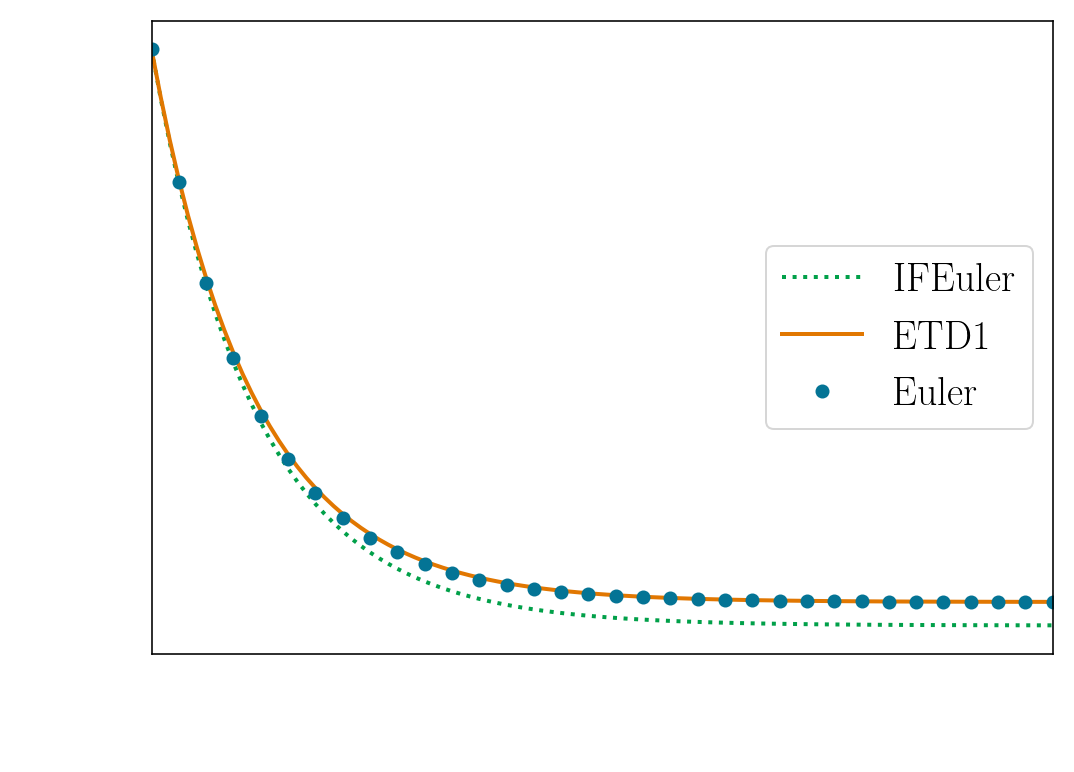

In [5]:
# Plot solution
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

tt=np.linspace(0,T,N)

plt.plot(tt, y_IF-y_eq, linewidth=2, color='xkcd:emerald', linestyle='dotted')
plt.plot(tt, y_ETD1-y_eq, linewidth=2, color='xkcd:pumpkin', linestyle='solid')
plt.plot(tt[::3], y_euler[::3]-y_eq, 'o',linewidth=2, color='xkcd:sea blue')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlim([0,T])
#plt.ylim([0.9*y0, 1.1*x0])

plt.legend(['IFEuler', 'ETD1', 'Euler'], loc='center right', fontsize=20)

plt.xlabel(r"$t$", fontsize=30, color = 'w')
plt.ylabel(r"$y(t)-y_{*}$", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

So, forward Euler and ETD1 both agree to the naked eye, and both reproduce the relaxation process nicely. IFEuler, however, clearly gets the wrong equilibrium with a step size of $h=0.05$! For such an easy problem, this type of mistake is fatal, even though it can be fixed by shrinking the step size (but if you're dealing with one of the only problems where **forward Euler can be used as a benchmark**, having to shrink the step size is the kiss of death). 

# Example 2: van der Pol Oscillator 

Now a tougher example: the famously stiff van der Pol oscillator. For a real parameter $\mu>0$, this takes the form
$$ \frac{\mathrm{d}}{\mathrm{d}t}\begin{bmatrix} x(t) \\ y(t)\end{bmatrix} = \begin{bmatrix}0 & 1 \\ -1 & \mu\end{bmatrix}\begin{bmatrix} x(t) \\ y(t)\end{bmatrix} + \begin{bmatrix} 0 \\ -x^2y\end{bmatrix} \quad \text{such that} \quad \begin{bmatrix} x(t) \\ y(t)\end{bmatrix} = \begin{bmatrix} x_0 \\ y_0\end{bmatrix}$$
(you can specify your own $x_0, y_0$ in the code... as long as both are nonnegative it doesn't matter much here since attraction to the limit cycle is so strong). We'll find that IFEuler again does a mediocre job, but ETD1 is quite close to the solution computed with scipy's built-in LSODA solver (not a bad feat for an order 1 scheme)! There is a caveat about time-step sizes here, but I'll talk about that at the end of the demo.  

We start by prescribing $\mu$ and the simulation parameters. 

In [6]:
T = 55. # simulation endtime
h = 1e-2 # prescribe timestep, typically around 1e-2 (see discussion below)
N = np.int(T/h) # total number of timesteps

mu = 8. # prescribe parameter mu appearing in the oscillator


Next, we define the linear part of the van der Pol system. 

In [7]:
A = np.array([[0.,1.],[-1.,mu]])

You may ask a natural question: when working with the propagator $e^{hA}$ in either of our VoP-based methods, should we try to use an exact expression, or is an approximate one OK? Let's see how different the exact and approximate expressions are. 

With a bit of work, we can the derive exact expressions for the linear propagator $e^{tA}$. I'll just input them in the code below, as the formulas are a bit cumbersome. TODO: add $\mu=2$ case.  

In [8]:
if 0<mu<2:
    omega = np.sqrt(1. - 0.25*mu**2)
    
    propagator_exact = np.zeros((2,2), dtype=float)

    propagator_exact[0,0] = np.cos(omega*h) -(mu/(2.*omega))*np.sin(omega*h)
    propagator_exact[0,1] = (1./omega)*np.sin(omega*h)
    propagator_exact[1,0] = 0.5*mu*propagator_exact[0,0]-omega*(np.sin(omega*h) +(mu/(2.*omega))*np.cos(omega*h))
    propagator_exact[1,1] = (mu/(2.*omega))*np.sin(omega*h)+np.cos(omega*h)

    propagator_exact *= np.exp(0.5*mu*h)
    
elif mu >= 2: 
    
    rplus = 0.5*(mu + np.sqrt(mu**2-4.))
    rmin = 0.5*(mu - np.sqrt(mu**2-4.))
    
    propagator_exact = np.zeros((2,2), dtype=float)

    propagator_exact[0,0] = -(rplus/(rmin-rplus))*np.exp(rmin*h) + (rmin/(rmin-rplus))*np.exp(rplus*h)
    propagator_exact[0,1] = (1./(rmin-rplus))*(np.exp(rmin*h)-np.exp(rplus*h))
    propagator_exact[1,0] = (rmin*rplus/(rmin-rplus))*(-np.exp(rmin*h)+np.exp(rplus*h))
    propagator_exact[1,1] = (1./(rmin-rplus))*(rmin*np.exp(rmin*h)-rplus*np.exp(rplus*h))  
    

We can also just use the built-in scipy matrix exponentiator to approximate the propagator. This routine uses Pade approximation to compute matrix exponentials, following Al-Mohy and Higham's scaling-and-squaring procedure (https://doi.org/10.1137/09074721X). 

In [9]:
propagator_approx = scipy.linalg.expm(h*A)

As the next line shows, the difference between exact and approximate propagators is pretty much negligible.  

In [10]:
print(scipy.linalg.norm(propagator_exact-propagator_approx, ord=2.))

2.286051835794552e-16


Therefore, for this relatively simple $2\times 2$ problem, we are free to use the approximate propagator with no shame. 

Now, we prescribe the initial conditions, initialize our storage of the computed solutions, and introduce the nonlinear forcing term. 

In [11]:
# define initial state
x0 = 1. # initial position
y0 = 0. # initial velocity

z = np.zeros((2,N), dtype=float) # store solution as a bunch of column vectors
z[:,0] = np.array([x0, y0]).T

In [12]:
# define nonlinear forcing term
def forcing(z):
    out = np.array([0.,-mu*z[1]*z[0]**2]).T
    return out

We do the time-stepping for IFEuler first. 

In [13]:
for n in np.arange(1,N): 
    z[:,n] = propagator_approx @ (z[:,n-1] + h*forcing(z[:,n-1]))

z_IF = np.copy(z) # redefine so we can overwrite z 

Next, we look at EDT1. For a $2\times 2$ problem, EDT1 can be implemented in a single block of code while keeping everything perfectly clear. 

In [14]:
A_inv = np.array([[mu,-1.],[1.,0.]]) # inverse of A can be found exactly

phi1 =  A_inv @ (propagator_approx-np.eye(2))
# notice that we do not include the extra 1/h in phi1 since we multiply 
# by h again in the time-stepping. Obviously good for error to not actually
# do this cancellation in practice!

for n in np.arange(1,N): 
    z[:,n] = z[:,n-1] + phi1 @ (forcing(z[:,n-1]) +A@z[:,n-1])
    # this is equivalent to 
    # z[:,n] = propagator_approx @ (z[:,n-1] + phi1 @ forcing(z[:,n-1]))
    # which appears simpler, but does not generalize efficiently to high-dimensional systems
    #print(z[:,n])
    
z_ETD1 = np.copy(z)

We now obtain a "benchmark" numerical solution using the scipy implementation of LSODA (which automatically detects and accounts for stiffness). 

In [15]:
def RHS(t,z):
    out  = forcing(z) + A@z
    return out 

outs_lsoda = scipy.integrate.solve_ivp(RHS, (0,T), z[:,0], method='LSODA', t_eval =np.linspace(0,T,N) )
# NOTE: in my experiments, for h = 0.1, there is no change in going from automatic
# step selection to making t_eval the same as it is for our homemade routines
t_lsoda = outs_lsoda['t']
z_lsoda = outs_lsoda['y']

At last, we see how IFEuler and ETD1 compare against one another.  

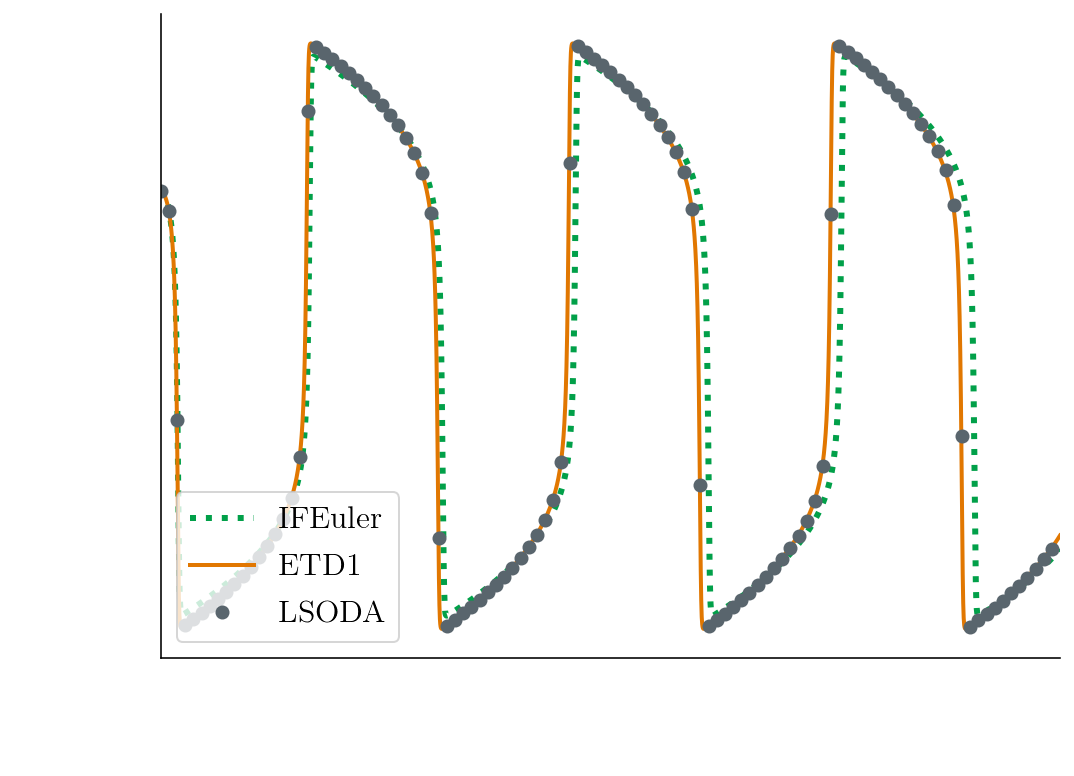

In [16]:
# Plot solution
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

t=np.linspace(0,T,N)

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.plot(t, z_IF[0,:], linewidth=3 , color='xkcd:emerald', linestyle='dotted')
plt.plot(t, z_ETD1[0,:], linewidth=2, color='xkcd:pumpkin', linestyle='solid')
#plt.plot(t, z_ETD1[1,:], linewidth=2, color='xkcd:sea blue', linestyle='solid')
plt.plot(t_lsoda[::50], z_lsoda[0,:][::50], 'o', color='xkcd:slate grey')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlim([0,T])

plt.legend(['IFEuler', 'ETD1', 'LSODA'], loc='lower left', fontsize=16)
#plt.legend(['$x(t)$', '$\dot{x}(t)$'], loc='lower left', fontsize=16)

plt.xlabel(r"$t$", fontsize=30, color = 'w')
plt.ylabel(r"$x(t)$", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

For $\mu>2$, ETD1 is clearly the superior scheme: IFEuler eventually develops a noticeable phase difference from the LSODA solution! For $\mu< 2$, IFEuler does pretty much just as well as ETD1, but we don't want our solver quality to be so parameter-dependent. We can quantify the difference between IFEuler and ETD1 by computing mean-square relative errors: 

In [17]:
error_est_0 = np.linalg.norm(z_IF[0,:]- z_lsoda[0,:], ord=2) 
error_est_1 = np.linalg.norm(z_ETD1[0,:]- z_lsoda[0,:], ord=2) 
true_l2 = np.linalg.norm(z_lsoda[0,:], ord=2) 

print('Percent Relative L^2 Deviation of IFEuler from LSODA =', '{:.2f}'.format(100.*error_est_0/true_l2), '%')
print('Percent Relative L^2 Deviation of ETD1 from LSODA =','{:.2f}'.format(100*error_est_1/true_l2), '%')

Percent Relative L^2 Deviation of IFEuler from LSODA = 33.48 %
Percent Relative L^2 Deviation of ETD1 from LSODA = 3.10 %


I reiterate that it's quite striking how close ETD1 is to LSODA despite being a pretty naive method! In conclusion, we've found that ETD1 is definitely the correct way to discretize VoP: IFEuler simply can't compete. 

## Some Philosophy: Truly Nonlinear Instability in Simulating van der Pol
A final, but spiritually important, remark is in order. This is more about discretizing nonlinear systems than exponential integrators per se, but it still bears discussion. For the van der Pol oscillator, step size still needs to be pretty small ($h = 10^{-2}$ or thereabouts) to get numerical stability in ETD1 and IFEuler. That is, for larger $h$ the numerical solution becomes unbounded in a few steps. You may ask how this can be for ETD1, which is provably A-stable. The secret is that the instability is a truly nonlinear feature and therefore cannot be addressed by A-stability! Here's why: try setting $h=0.1$ and $\mu=4$. Plot both $x(t)$ AND $y(t)=\dot{x}(t)$. You'll see little wiggles in $x(t)$ and dramatic oscillations in $y(t)$ near where the solution jumps suddenly to a local extremum. These wiggles arise because the grid is too coarse to properly account for a natural time scale in the problem, namely the time elapsed when $x(t)$ jumps suddenly up to its maximum (or down to its minimum). As $\mu$ increases, this jump becomes sharper and sharper... indeed, if you slowly crank $\mu$ up to $\mu=5$, you'll see the wiggles in $x(t), y(t)$ get bigger and bigger until finally the instability becomes too great and the time-stepping encounters overflow. In more detail, if the grid size is too large, the jump occurs within a single grid cell. So, in the time after a jump, we use the wrong sign of derivative in computing our new solution value! This leads to a push-and-pull as the simulation fails to correctly see $y\approx 0$ at the extremum near the jump. The signature of that push-and-pull is the tiny unphysical wiggles we see in the pictures. If $\mu$ is large, the jump is too sharp, and such unphysical oscillations start to become much worse than tiny, and abracadabra the solution blows up. 

The lesson here is that stiffness/A-stability is not the only thing to keep in mind when numerically solving ODEs: sometimes truly nonlinear features of a dynamical system (here, the uniquely sharp oscillations in the van der Pol system's limit cycle) also introduce time-step restrictions. 